In [1]:
IS_LINUX = False
from sys import platform
if platform == "linux" or platform == "linux2":
  IS_LINUX = True
#import os
#os.environ["CUDA_VISIBLE_DEVICES"]="-1"    
if IS_LINUX:
    !pip install tensorflow-gpu
    !pip install jsonpickle

In [2]:
if IS_LINUX:
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [3]:
if IS_LINUX:
    %cd /content/drive/My\ Drive/MastersThesis
    !ls
    !pwd
    import sys
    sys.path.append('./')

/content/drive/My Drive/MastersThesis
Autoencoderstart.ipynb	datasets.py	     named_constants.py  README.md
config.py		global_functions.py  output_dir
constants.py		models.py	     __pycache__
/content/drive/My Drive/MastersThesis


In [4]:
import global_functions
global_functions.on_start()

True
1 Physical GPUs, 1 Logical GPUs
GPU OK


In [5]:

# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

print(tf.__version__)
import matplotlib.pyplot as plt

2.0.0


In [0]:
from datasets import MnistDataset

dataset = MnistDataset()


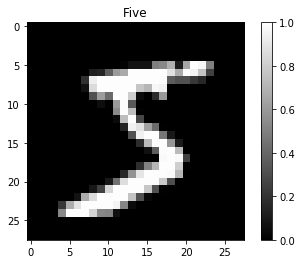

In [7]:
def plotImage(image, title = None):
  plt.figure()
  plt.imshow(image)
  if title is not None:
    plt.title(title)      
  plt.colorbar()
  plt.grid(False)
  plt.gray()
  plt.show()

plotImage( dataset.process_image_for_plotting(dataset.get_train_images()[0]), dataset.get_train_label_class_name(0))

In [0]:
from models import BasicModelBuilder

import datasets

models = BasicModelBuilder(datasets.MnistDataset().get_input_shape(),
                           datasets.MnistDataset().get_number_of_classes()).create_models()


Using TensorFlow backend.


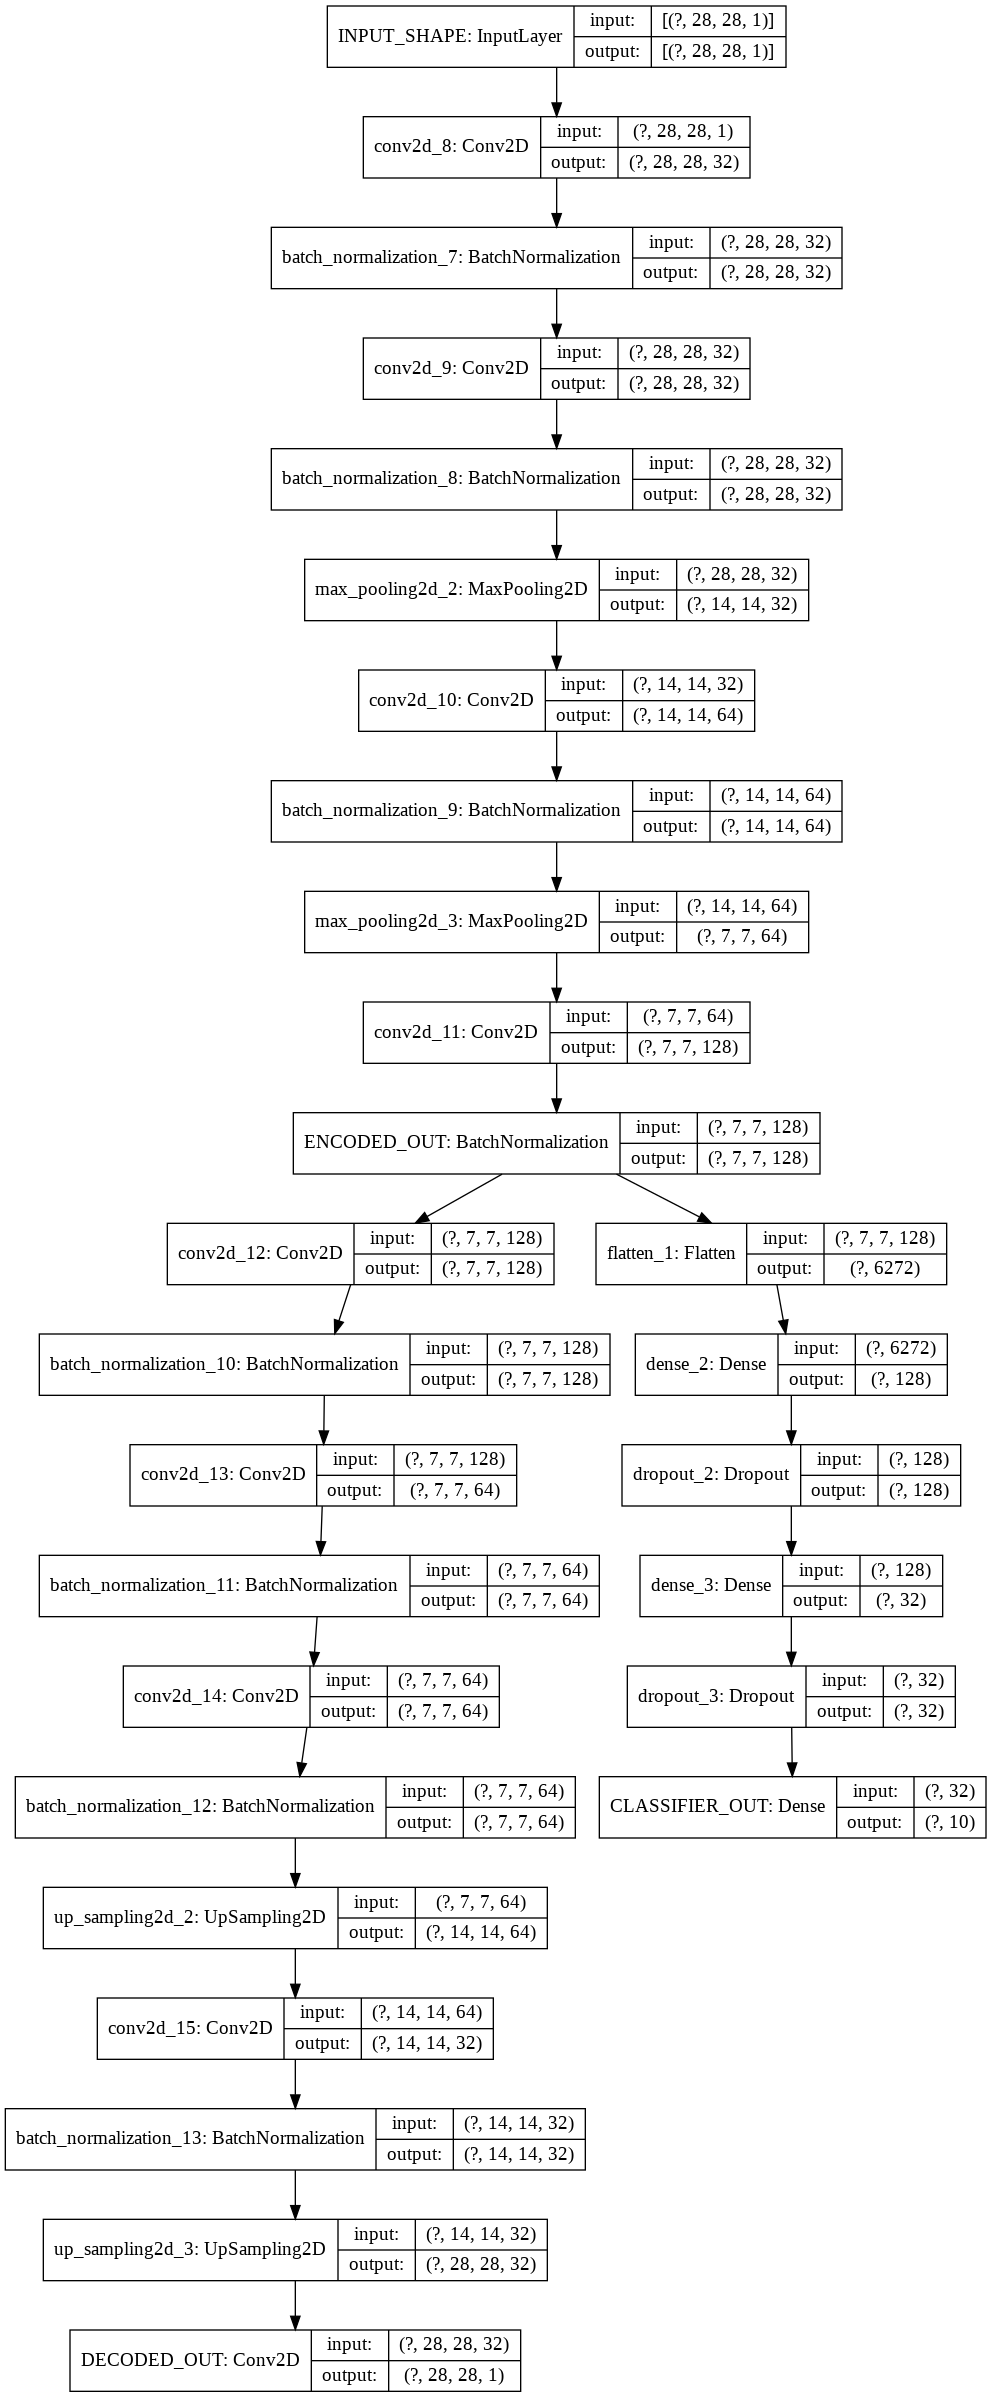

In [9]:
from keras.utils import plot_model
keras.utils.plot_model(models.auto_classifier, show_shapes=True, to_file = 'model_combined.png')
# keras.utils.plot_model(decoder, show_shapes=True, to_file = 'model_combined.png')
#auto_classifier.summary()

In [0]:
from functools import wraps
import json
import codecs
from pathlib import Path
from datetime import datetime

#def get_log_dictionary(): 


class Logger():
    
    AUTOENCODE_OUTPUTH_PATH = 'model_autoencoder_log.json'
    
    ROOT_KEY = 'modellist'
    MODEL_KEY = 'model'
    HISTORY_NODE_KEY = 'training_history'
    HISTORY_KEY = 'history'
    PARAMS_KEY = 'params'
    MODEL_PATH = 'path_to_model'        
    

    def __init__(self, logfile = OUTPUT_DIRECTORY + 'model_default_log.json', save_whole_model = False):
        self.logfile = logfile
        self.save_whole_model = save_whole_model        
        
    @staticmethod
    def convert_dictionary(dictionary):
        new_hist = {}
        for key in list(dictionary.keys()):
            if type(dictionary[key]) == np.ndarray:
                new_hist[key] = dictionary[key].tolist()
            elif type(dictionary[key]) == list:
                if  type(dictionary[key][0]) in (np.float64, np.float32):
                    new_hist[key] = list(map(float, dictionary[key]))
                else:
                    new_hist[key] = dictionary[key] 
            else:
                if type(dictionary[key]) in (np.int32, np.int64):
                    new_hist[key] = int(dictionary[key])
                else: 
                    new_hist[key] = dictionary[key]          
        return new_hist
    
    @staticmethod
    def serialize_history(history):
        history_dict = Logger.convert_dictionary(history.history)
        params_dict = Logger.convert_dictionary(history.params)
        return { Logger.HISTORY_KEY: history_dict, Logger.PARAMS_KEY : params_dict }
    
    def get_model_path(self):
        now = datetime.now()
        return OUTPUT_DIRECTORY + '_' + now.strftime("_%d_%m_%Y_%H_%M_%S") + '.h5'
    
    @staticmethod
    def get_log(logfile, initialize_if_empty = True):
        print('Logfile: ' + logfile)
        default_dict = { Logger.ROOT_KEY : [] }
        path_to_logfile = Path(logfile)
        if Path(path_to_logfile).exists():
            text = Path(path_to_logfile).read_text()
            return json.loads(text)
        else:
            if initialize_if_empty:
                return default_dict
            else:
                None

    def log_history(self, history, logfile = None):
        if logfile is None:
            logfile = self.logfile            
        model_to_dictionary = history.model.get_config()
#             # Open the logfile and append
        result_dictionary = Logger.get_log(self.logfile)
        with codecs.open(self.logfile, 'w', encoding = 'UTF-8') as opened_file:
            # Now we log to the specified logfile
            history_dict = Logger.serialize_history(history)
            model_path = None
            if self.save_whole_model:
                model_path = self.get_model_path()
                history.model.save(model_path)
            current_history = {Logger.MODEL_KEY : model_to_dictionary, Logger.HISTORY_NODE_KEY : history_dict, Logger.MODEL_PATH : model_path}
            #current_history = {MODEL_KEY : 'model', PARAMS_KEY: 'parameter', TRAIN_HISTORY_KEY: 'trening' }
            result_dictionary[Logger.ROOT_KEY].append(current_history)
            opened_file.write(json.dumps(result_dictionary))
            #opened_file.write(str(result_dictionary))
        print("zapisane")

    def __call__(self, func):
        @wraps(func)
        def wrapped_function(*args, **kwargs):
            print('fungujem')
            history = func(*args, **kwargs)
            self.log_history(history, self.logfile)
            return history
        return wrapped_function
    
    @staticmethod
    def get_models_from_log(log):
        modellist = log[Logger.ROOT_KEY]
        result_list = []
        for model_info_dict in modellist:
            model_path = model_info_dict[Logger.MODEL_PATH];
            if (model_path is None):
                result_list.append(None)
            else:
                result_list.append(keras.models.load_model(model_path))
        return result_list

class MyHistory():
    
    def __init__():
        pass
    
    
class Metrics(Enum):   
    ACCURACY = 'acc'
    LOSS = 'loss'
    VAL_LOSS = 'val_loss'
    VAL_ACCURACY = 'val_accuracy'
    
    
    @staticmethod
    def get_data():
        return [data for data in Metrics]
    
class Vizualizer():
    
    @staticmethod
    def vizualize_history(history_dict, ignore = 0.2, metrics = Metrics.get_data()):
        metrics = [metric.value for metric in metrics]
        lines = []
        epochs = history_dict[Logger.PARAMS_KEY]['epochs']
        start_index = int(round(ignore * epochs))
        x = range(start_index , epochs)
        plt.figure(figsize=(10, 10))
        for metric, values in history_dict[Logger.HISTORY_KEY].items():
            #if next((s for s in metrics if metric in s.lower()), None) is not None:
            y = values[start_index:]
            plt.plot(x, y,'ro', label = metric)
            line, = plt.plot(x, y, label = metric)

            for i_x, i_y in zip(x, y):
              print(i_x, i_y)
              plt.text(i_x, i_y, '{0:.4f}'.format(round(i_y, 4)))

            lines.append(line)
            print('metric: ' + metric)
            print("Values: ", values)
        plt.legend(handles = lines)                     
        plt.xlabel('Epoch')
        plt.xticks(range(epochs))
        
        plt.show()
        
    
    @staticmethod
    def vizualize(log_dictionary, ignore = 0.2, metrics = Metrics.get_data()):
        modellist = log_dictionary[Logger.ROOT_KEY]
        for model_index, model_info_dict in enumerate(modellist):
            print('Model index: ' + str(model_index + 1))
            model = model_info_dict[Logger.MODEL_KEY]
            history_dict = model_info_dict[Logger.HISTORY_NODE_KEY]
            Vizualizer.vizualize_history(history_dict, ignore, metrics)
                

#1. Autoencodee solo                
#@Logger(logfile= OUTPUT_DIRECTORY + 'model_fashion_mnist_autoencoder.json', save_whole_model=True)
def train_autoencoder(epochs = 100, batch_size= 128):
    
    
    es = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2, min_delta = 0.005, restore_best_weights=True)
    mc = keras.callbacks.ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
    return autoencoder.fit(x = train_images, y = train_images, batch_size=batch_size, epochs=epochs, validation_data= (test_images, test_images), callbacks=[es, mc]), es                
                
#2. Classifier solo    
@Logger(logfile = OUTPUT_DIRECTORY + 'model_fashion_mnist_classifier.json', save_whole_model=True)
def train_classifier(epochs = 30, batch_size=128):
    return classifier.fit(x = train_images, y = train_labels_one_hot_encoding, batch_size=batch_size, epochs=epochs, validation_data= (test_images, test_labels_one_hot_encoding))

import time

def train_autoencoder_and_classifier_autoencoder_off(epochs = 20, batch_size=128):
    last_history_autoencoder = None
    last_history_classifier = None
    for epoch in range(epochs):
        set_autoencoder_trainable(True)
        last_history_autoencoder = autoencoder.fit(x = train_images, y = train_images, batch_size=batch_size, epochs=1, validation_data= (test_images, test_images))
        set_autoencoder_trainable(False)
        last_history_classifier = classifier.fit(x = train_images, y = train_labels_one_hot_encoding, batch_size=128, epochs=1, validation_data= (test_images, test_labels_one_hot_encoding))
    logger = Logger(logfile = OUTPUT_DIRECTORY + 'model_fashin_mnist_autoencoder_classifier_alternate_autooff.json', save_whole_model = True)
    logger.log_history(last_history_autoencoder)
    time.sleep(1.1)
    logger.log_history(last_history_classifier)
    
def train_autoencoder_and_classifier_autoencoder_on(epochs = 20, batch_size=128):
    last_history_autoencoder = None
    last_history_classifier = None
    set_autoencoder_trainable(True)
    for epoch in range(epochs):
        last_history_autoencoder = autoencoder.fit(x = train_images, y = train_images, batch_size=batch_size, epochs=1, validation_data= (test_images, test_images))
        last_history_classifier = classifier.fit(x = train_images, y = train_labels_one_hot_encoding, batch_size=128, epochs=1, validation_data= (test_images, test_labels_one_hot_encoding))
    logger = Logger(logfile = OUTPUT_DIRECTORY + 'model_fashin_mnist_autoencoder_classifier_alternate_auto_on.json', save_whole_model = True)
    logger.log_history(last_history_autoencoder)
    time.sleep(1.1)
    logger.log_history(last_history_classifier)        
        
def train_classificator_after_autoencoder_trained(epochs = 20, batch_size=128): 
    trained_autoencode_log = Logger.get_log(OUTPUT_DIRECTORY + 'model_fashion_mnist_autoencoder.json')
    trained_autoencoder = Logger.get_models_from_log(trained_autoencode_log)[0];
    for index, layer in enumerate(autoencoder.layers):
        layer.set_weights(trained_autoencoder.get_layer(index=index).get_weights())
    logger = Logger(logfile = OUTPUT_DIRECTORY + 'model_fashin_mnist_train_classificator_after_autoencoder_trained.json', save_whole_model = True)
    set_autoencoder_trainable(True)
    last_history_classifier = classifier.fit(x = train_images, y = train_labels_one_hot_encoding, batch_size=batch_size, epochs=epochs, validation_data= (test_images, test_labels_one_hot_encoding))
    logger.log_history(last_history_classifier)
    
def train_classificator_after_autoencoder_trained_off(epochs = 20, batch_size=128): 
    trained_autoencode_log = Logger.get_log(OUTPUT_DIRECTORY + 'model_fashion_mnist_autoencoder.json')
    trained_autoencoder = Logger.get_models_from_log(trained_autoencode_log)[0];
    for index, layer in enumerate(autoencoder.layers):
        layer.set_weights(trained_autoencoder.get_layer(index=index).get_weights())
    logger = Logger(logfile = OUTPUT_DIRECTORY + 'model_fashin_mnist_train_classificator_after_autoencoder_trained_off.json', save_whole_model = True)
    set_autoencoder_trainable(False)
    last_history_classifier = classifier.fit(x = train_images, y = train_labels_one_hot_encoding, batch_size=batch_size, epochs=epochs, validation_data= (test_images, test_labels_one_hot_encoding))
    logger.log_history(last_history_classifier)

@Logger(logfile= OUTPUT_DIRECTORY + 'model_fashion_mnist_autoclassifier.json', save_whole_model=True)    
def train_auto_classifier(epochs = 30, batch_size=128):
    return auto_classifier.fit(x = train_images, y = {'DECODED_OUT' : train_images, 'CLASSIFIER_OUT': train_labels_one_hot_encoding } , batch_size=batch_size, epochs= epochs, verbose= 1, validation_data= (test_images, {'DECODED_OUT' : test_images, 'CLASSIFIER_OUT': test_labels_one_hot_encoding }) )
    
history, es = train_autoencoder()
#train_classifier()
#train_autoencoder_and_classifier_autoencoder_off()
#train_autoencoder_and_classifier_autoencoder_on()
#train_classificator_after_autoencoder_trained()
#train_classificator_after_autoencoder_trained_off()
#train_auto_classifier()

#plt.figure(figsize=(20, 20))


#Vizualizer.vizualize(Logger.get_log(OUTPUT_DIRECTORY + 'model_fashion_mnist_autoencoder.json')) #train_autoencoder

#Vizualizer.vizualize(Logger.get_log(OUTPUT_DIRECTORY + 'model_fashion_mnist_classifier.json')) #train_classifier
#Vizualizer.vizualize(Logger.get_log(OUTPUT_DIRECTORY + 'model_fashin_mnist_autoencoder_classifier_alternate_autooff.json')) #train_autoencoder_and_classifier_autoencoder_off()

#Vizualizer.vizualize(Logger.get_log(OUTPUT_DIRECTORY + 'model_fashin_mnist_autoencoder_classifier_alternate_auto_on.json')) #train_autoencoder_and_classifier_autoencoder_on()

#Vizualizer.vizualize(Logger.get_log(OUTPUT_DIRECTORY + 'model_fashin_mnist_train_classificator_after_autoencoder_trained.json')) #train_classificator_after_autoencoder_trained

#Vizualizer.vizualize(Logger.get_log(OUTPUT_DIRECTORY + 'model_fashin_mnist_train_classificator_after_autoencoder_trained_off.json')) #train_classificator_after_autoencoder_trained_off()

#Vizualizer.vizualize(Logger.get_log(OUTPUT_DIRECTORY + 'model_fashion_mnist_autoclassifier.json')) # train_auto_classifier()


#history = train_autoencoder(epochs = 1)
#Vizualizer.vizualize_history(Logger.serialize_history(history))


# Vizualizer.vizualize(Logger.get_log(Logger.AUTOENCODE_OUTPUTH_PATH), ignore= 0.3)
#trainClassifier(epochs = 20)
#trainClassifier(epochs = 5)
# @run_once
# def assign_classifier():
#   CLASSIFIER_OUTPUT_PATH = 'classifier training.txt'
#   classifier.fit = logit(CLASSIFIER_OUTPUT_PATH) (classifier.fit)

# assign_classifier()
#Vizualizer.vizualize(Logger.get_log(Logger.AUTOENCODE_OUTPUTH_PATH), ignore = 0.0)

Train on 60000 samples, validate on 10000 samples
Epoch 1/100
60000/60000 [==============================] - 20s 327us/sample - loss: 0.3061 - val_loss: 0.3005
Epoch 2/100
60000/60000 [==============================] - 18s 293us/sample - loss: 0.2629 - val_loss: 0.2671
Epoch 3/100
60000/60000 [==============================] - 18s 293us/sample - loss: 0.2578 - val_loss: 0.2633
Epoch 4/100
60000/60000 [==============================] - 18s 298us/sample - loss: 0.2551 - val_loss: 0.2615
Epoch 5/100
60000/60000 [==============================] - 18s 292us/sample - loss: 0.2536 - val_loss: 0.2609
Epoch 6/100
60000/60000 [==============================] - 17s 291us/sample - loss: 0.2525 - val_loss: 0.2542
Epoch 7/100
60000/60000 [==============================] - 17s 289us/sample - loss: 0.2516 - val_loss: 0.2537
Epoch 8/100
60000/60000 [==============================] - 18s 292us/sample - loss: 0.2510 - val_loss: 0.2529
Epoch 00008: early stopping


In [0]:
epochs = 1
#print("Epoch {}".format(epoch))
# print("AutoClassifier")
# historyAutoClassifier = auto_classifier.fit(x = train_images, y = {'DECODED_OUT' : train_images, 'CLASSIFIER_OUT': train_labels_one_hot_encoding } , batch_size=128, epochs= epochs, verbose= 1)
# print("Autoencoder")
# set_autoencoder_trainable(True)
# historyAutoencoder = autoencoder.fit(x = train_images, y = train_images, batch_size=128, epochs= epochs)
#set_autoencoder_trainable(False)


es.__dict__

{'validation_data': None,
 'model': <tensorflow.python.keras.engine.training.Model at 0x1d634a01ba8>,
 '_chief_worker_only': None,
 'monitor': 'val_loss',
 'patience': 2,
 'verbose': 1,
 'baseline': None,
 'min_delta': -0.005,
 'wait': 2,
 'stopped_epoch': 2,
 'restore_best_weights': True,
 'best_weights': [array([[[[-3.16931754e-02,  5.09581566e-02, -4.29900512e-02,
            -9.35420841e-02,  2.75679119e-02,  3.08399890e-02,
             1.73841462e-01, -1.62299842e-01, -8.42970982e-02,
             1.67379379e-01,  1.17307946e-01, -9.03630629e-03,
             1.16768733e-01, -6.83555007e-03, -1.26180410e-01,
             9.73619171e-04,  1.72443837e-02,  8.51745065e-03,
            -8.02972987e-02,  9.46384296e-02, -2.12343782e-02,
            -8.71663168e-02,  9.44179147e-02, -1.22939818e-01,
             8.82129669e-02, -7.57588506e-01, -2.55035069e-02,
             1.28370494e-01, -3.61297862e-03, -3.39806266e-02,
            -1.43827856e-01,  1.27377138e-01]],
  
          [[

In [0]:
class History():
    
    def __init__():
        self.history = {}
        self.params = {}
        
    def append(history, model = None):
        history.history
        history.params = 

In [0]:
def make_batches(to_batch, batch_size = 128):
    return [to_batch[i * batch_size:(i + 1) * batch_size] for i in range((len(to_batch) + batch_size - 1) // batch_size )]

batch_size = 128
to_batch = tf.data.Dataset.from_tensor_slices((train_images, keras.utils.to_categorical(train_labels, 10) ))
train_batched = to_batch.batch(batch_size)

In [0]:
epochs = 10
for epoch in range(epochs):
    print("Epoch: {}", epoch)
    for step, (images, labels) in enumerate(train_batched):
        set_autoencoder_trainable(True)
        with tf.GradientTape() as tape:
          prediction = autoencoder(images)
          loss_autoencoder = autoencoder.loss(images, prediction)
          gradients = tape.gradient(loss_autoencoder, autoencoder.trainable_variables)
          autoencoder.optimizer.apply_gradients(zip(gradients, autoencoder.trainable_variables))  
        set_autoencoder_trainable(False)
        with tf.GradientTape() as tape:
          predict_class = classifier(images)
          loss_classifier = classifier.loss(labels, predict_class)  
#           classiefier_trainable = classifier_head.trainable_variables
          classiefier_trainable = classifier.trainable_variables
          gradients = tape.gradient(loss_classifier, classiefier_trainable)
          classifier.optimizer.apply_gradients(zip(gradients  ,classiefier_trainable) ) 
          if step % 10 == 0:
              print("Step: {}, loss autoencoder: {}, loss classifier: {}".format(step, loss_autoencoder.numpy().mean(), loss_classifier.numpy().mean()))


In [0]:
for epoch in range(5):
  print("Classifier")
  historyClassifier = classifier.fit(x = train_images, y = train_labels_one_hot_encoding, batch_size=128, epochs=1, validation_data= (test_images, test_labels_one_hot_encoding))

Classifier
Train on 60000 samples, validate on 10000 samples
53120/60000 [=========================>....] - ETA: 1s - loss: 0.6407 - accuracy: 0.7852 ETA: 7s - l - ETA: 5s - loss: - ETA: 4s - loss: 0.6843 - accu -

KeyboardInterrupt: 

In [0]:
predictions_auto_encoder, predictions_classifier = auto_classifier.predict(test_images)
predictions_classifier = np.argmax(np.round(predictions_classifier),axis=1)
correct = np.where(predictions_classifier==test_labels)[0]
print( "Found {} correct labels".format(len(correct)))

In [0]:

test_eval = classifier.evaluate(test_images, test_labels_one_hot_encoding, verbose=0)
print('Test loss:', test_eval[0])
print('Test accuracy:', test_eval[1])
predicted_classes = classifier.predict(test_images)
predicted_classes = np.argmax(np.round(predicted_classes),axis=1)
predicted_classes = predicted_classes.astype('uint8')
correct = [predicted_classes[i] == value for i, value in enumerate(test_labels)]
print("Correct: {}".format( correct.count(True)))




Test loss: 3.031718700027466
Test accuracy: 0.0883
Correct: 1043


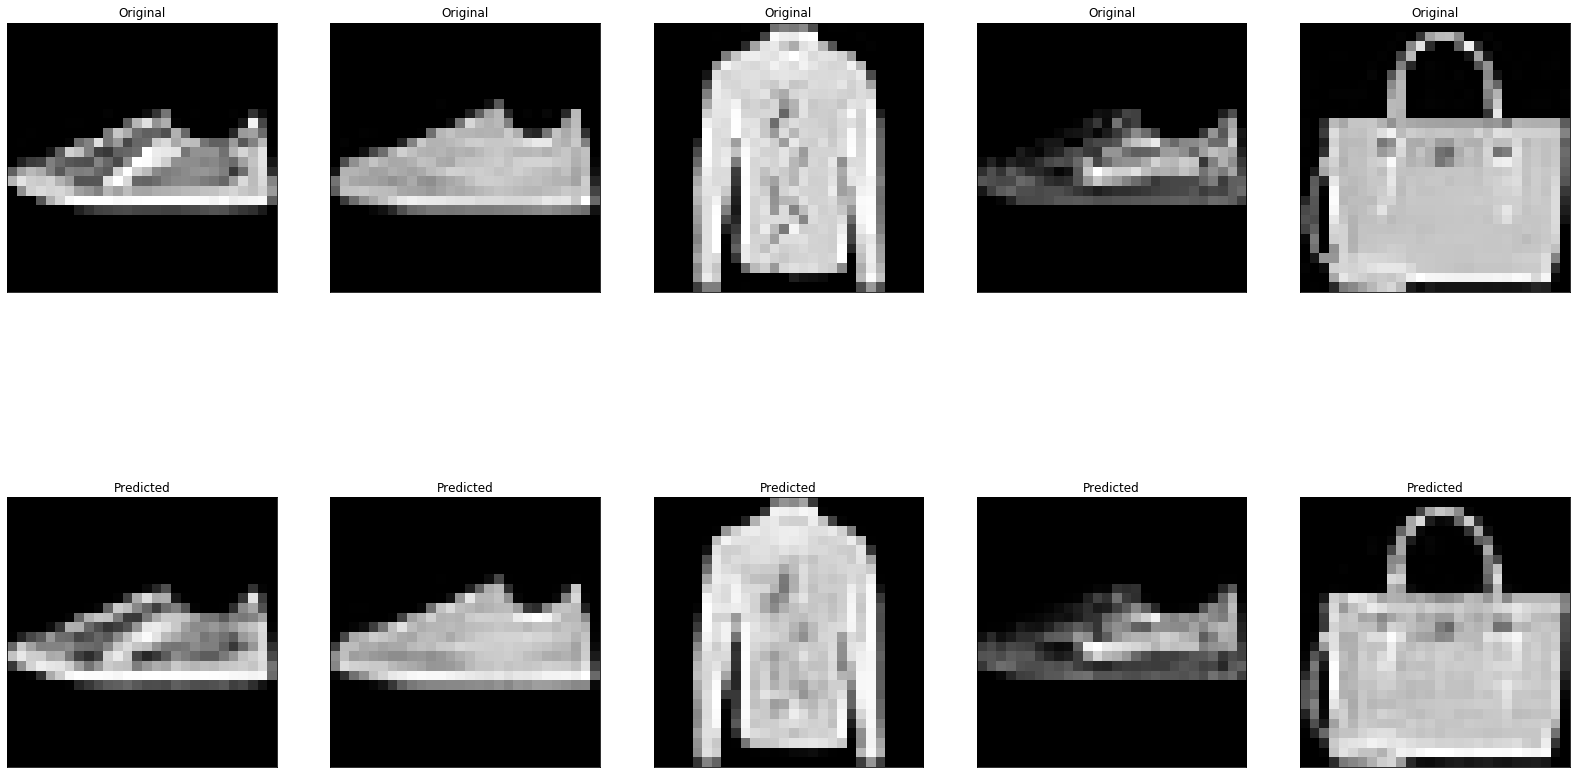

In [0]:
predictions = autoencoder.predict(test_images)
# rand_start = np.random.randint(0, len(predictions) - 10)
# for i in range(rand_start, rand_start + 10):
#   plotImage(predictions[i].reshape(28, 28), "Predictions")
#   plotImage(test_images[i].reshape(28, 28), "Original")


num_images = 5
#np.random.seed(42)
random_test_images = np.random.randint(test_images.shape[0], size=num_images)

decoded_imgs = predictions


plt.figure(figsize=(28, 16))

for i, image_idx in enumerate(random_test_images):
    # plot original image
    ax = plt.subplot(2, num_images, i + 1)
    plt.title("Original")
    plt.imshow(process_for_plotting(test_images[image_idx]))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    # # plot encoded image
    # ax = plt.subplot(3, num_images, num_images + i + 1)
    # plt.imshow(encoded_imgs[image_idx].reshape(8, 4))
    # plt.gray()
    # ax.get_xaxis().set_visible(False)
    # ax.get_yaxis().set_visible(False)

    # plot reconstructed image
    ax = plt.subplot(2, num_images, num_images + i + 1)
    plt.imshow(process_for_plotting(decoded_imgs[image_idx])) #reshape(28, 28)
    plt.title("Predicted")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [0]:
class MetaConst(type):

    def __getattr__(cls, key):
        print('key' ,key)
        return type.__getattr__(cls, key)
        #return cls[key]

    def __setattr__(cls, key, value):
        print('key', key, ' value', value, 'class', cls)
        type.__setattr__(cls, key, value)
        #setattr(cls, key, value)
        #cls.__dict__[key] = value
        #raise TypeError

class Const(object, metaclass=MetaConst):
    
    #def __getattr__(self, name):
    #   return self[name]

    def __setattr__(self, name, value):
        self.__dict__[name] = value
        print(self.__dict__) 
        #raise TypeError        
        
class MyConstant(Const):
    
    FIELD_NAME = 'constants'
    
    def __init__(self, value, cls):
        self.value = value
        if not hasattr(cls, MyConstant.FIELD_NAME):
            setattr(cls, MyConstant.FIELD_NAME, [])
        constants = getattr(cls, MyConstant.FIELD_NAME)
        constants.append(self)
            
    def __call__(self):
        return self.value
 
    

In [0]:

class MyClass():
    
    #const = MyConstant("a", MyClass)
    
    def __init__(self):
        pass

#MyClass.const()
MyConstant.FIELD_NAME = '10'
so = getattr(MyConstant, 'FIELD_NAME')
so

key FIELD_NAME  value 10 class <class '__main__.MyConstant'>


'10'

In [0]:
def injectArguments(inFunction):
    """
    Decorator injecting arguments of a method as attributes

    Found here: http://code.activestate.com/recipes/577382-keyword-argument-injection-with-python-decorators/

    """

    def outFunction(*args, **kwargs):
        _self = args[0]
        _self.__dict__.update(kwargs)

        # Get all of argument's names of the inFunction
        _total_names = inFunction.__code__.co_varnames[1:inFunction.__code__.co_argcount]
        
        print(_total_names)
        # Get all of the values
        _values = args[1:]
        # Get only the names that don't belong to kwargs
        _names = [n for n in _total_names if not n in kwargs]

        # Match argument names with values and update __dict__
        _self.__dict__.update(zip(_names,_values))

        # Add default value for non-specified arguments
        nb_defaults = len(_names) - len(_values)
        _self.__dict__.update(zip(_names[-nb_defaults:], inFunction.__defaults__[-nb_defaults:]))

        return inFunction(*args,**kwargs)

    return outFunction

In [0]:
class Test:
    @injectArguments
    def __init__(self, name, surname, default='lol'):
        pass

t = Test('mickey', surname='mouse')
assert(t.name == 'mickey' and t.surname == 'mouse' and t.default == 'lol')

('name', 'surname', 'default')


In [0]:
print([const.value for const in MyClass.constants])

AttributeError: type object 'MyClass' has no attribute 'constants'

In [0]:
class Mine():
    
    def __init__(self):
        self.a = 10
        
import jsonpickle

mine = Mine()
json_object = jsonpickle.encode(mine)
mine_copy = jsonpickle.decode(json_object)


In [0]:
def my_func(bla, ble, ki = 20, *arg, **kwargs):
    print(locals())
    print(bla, ble, ki)
    print('arg', arg)
    
d = { 'ble':20, 'la':[10]}
ar = [0,2,3]
my_func(**d, *ar)

SyntaxError: iterable argument unpacking follows keyword argument unpacking (<ipython-input-38-cbeb8c9b292e>, line 8)

In [0]:
class Door:
    colour = 'brown'

    def __init__(self, number, status):
        self.number = number
        self.status = status

    @classmethod
    def knock(cls):
        print("Knock!")

    def open(self):
        self.status = 'open'

    def close(self):
        self.status = 'closed'


In [0]:
o = Door(10, 20)
type(o.open)

method